# Neural Networks: Introduction and Forward Propagation

## What is a Neural Network?

A **neural network (NN)** is a computational model inspired by the structure and function of the human brain. 
At its core, a neural network is a sophisticated function that learns to map inputs to outputs through examples.

### Key Components

- **Neurons**: The basic computational units that receive inputs, process them, and produce an output
- **Layers**: Neurons are organized in layers:
  - **Input layer**: Receives the raw data
  - **Hidden layer(s)**: Intermediate layers that transform the data
  - **Output layer**: Produces the final prediction
- **Weights and Biases**: Learnable parameters that control the transformation at each layer
- **Activation Functions**: Non-linear functions applied to neuron outputs (e.g., sigmoid, ReLU)

### Why Neural Networks?

Neural networks excel at:
- Learning complex, non-linear patterns in data
- Automatic feature extraction (no manual feature engineering needed)
- Handling high-dimensional data (images, text, audio)
- Achieving state-of-the-art performance on many tasks

In this notebook, we'll build a **2-layer neural network** for binary classification using the breast cancer dataset.


In [1]:
# Import required libraries
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Dataset Preparation

We'll use the **breast cancer dataset** for binary classification. 
The task is to predict whether a tumor is **benign (B)** or **malignant (M)** based on various features extracted from cell nuclei images.

This is a real-world medical diagnosis problem where:
- **Input**: 10 numerical features describing cell characteristics
- **Output**: Binary label (0 = benign, 1 = malignant)


In [2]:
# Load the breast cancer dataset
data = pd.read_csv(
    "https://raw.githubusercontent.com/changyaochen/MECE4520/master/"
    "data/breast_cancer.csv"
)

# Convert diagnosis to binary label: 0 = Benign, 1 = Malignant
data["label"] = data["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Display first few rows
print(f"Dataset shape: {data.shape}")
print(f"\nClass distribution:")
print(data["label"].value_counts())
print(f"\nSample data:")
data.head()


Dataset shape: (569, 33)

Class distribution:
label
0    357
1    212
Name: count, dtype: int64

Sample data:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,...,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### Feature Selection and Preprocessing

We'll select 10 key features that describe the tumor characteristics. Before feeding data into a neural network, it's crucial to:

1. **Standardize the features**: Neural networks are sensitive to the scale of input features. Standardization (zero mean, unit variance) ensures:
   - Faster convergence during training
   - More stable gradient computations
   - Equal importance given to all features initially

2. **Split into train/test sets**: We need separate data for training and evaluation to assess generalization performance.


In [3]:
# Select features for the model
features = [
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_mean",
    "symmetry_mean",
    "fractal_mean",
]
label = "label"

# Split into train and test sets (80/20 split)
X_raw, X_raw_test, y, y_test = train_test_split(
    data[features].values,
    data[label].values,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {X_raw.shape[0]}")
print(f"Test samples: {X_raw_test.shape[0]}")
print(f"Number of features: {X_raw.shape[1]}")

# Standardize the features
# Important: Fit the scaler only on training data to avoid data leakage
scaler = StandardScaler()
scaler.fit(X_raw)
X = scaler.transform(X_raw)
X_test = scaler.transform(X_raw_test)

# Reshape labels to column vectors for matrix operations
y = y.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))


Training samples: 455
Test samples: 114
Number of features: 10


## Neural Network Architecture

We'll construct a **2-layer neural network** with the following structure:

```
Input Layer (10 features)
       ↓
Hidden Layer (3 neurons with sigmoid activation)
       ↓
Output Layer (1 neuron with sigmoid activation)
```

### Understanding the Architecture

For a single sample $ x = [x_1, x_2, \ldots, x_{10}]^T \in \mathbb{R}^{10 \times 1} $:

- **Layer 1 (Hidden Layer)**:
  - Takes 10 features as the input
  - Has 3 neurons (hidden units)
  - For each neuron $ i $, there is a weight vector $ w_i^{[1]} \in \mathbb{R}^{10 \times 1} $, and a scalar $ b_i^{[1]} \in \mathbb{R} $
  - Each neuron computes the activation: $ a_i^{[1]} = \sigma(z_i^{[1]}) = \sigma((w_i^{[1]})^T x + b_i^{[1]}) \in \mathbb{R} $. Here we use the sigmoid activation function
  - The output from all 3 neurons are concatenated to form a vector $ a^{[1]} \in \mathbb{R}^{3 \times 1} $
  - $ a^{[1]} = \sigma(z^{[1]}) = \sigma(W^{[1]} x + b^{[1]}) \in \mathbb{R}^{3 \times 1} $, where $ W^{[1]} \in \mathbb{R}^{3 \times 10} $ and $ b^{[1]} \in \mathbb{R}^{3 \times 1} $

- **Layer 2 (Output Layer)**:
  - Takes output $ a^{[1]} \in \mathbb{R}^{3 \times 1} $ from the hidden layer as the input
  - Has 1 neuron (for binary classification)
  - Computes: $ \hat{y} = \sigma(W^{[2]} a^{[1]} + b^{[2]}) \in \mathbb{R} $, where $ W^{[2]} \in \mathbb{R}^{1 \times 3} $ and $ b^{[2]} \in \mathbb{R}$

### Why These Shapes?

The matrix dimensions are designed so that matrix multiplication works correctly:
- $ W^{[1]} \in \mathbb{R}^{3 \times 10} $: connects 10 inputs to 3 hidden neurons
- $ b^{[1]} \in \mathbb{R}^{3 \times 1} $: bias for each of 3 hidden neurons
- $ a^{[1]} \in \mathbb{R}^{3 \times 1} $: output from the hidden layer
- $ W^{[2]} \in \mathbb{R}^{1 \times 3} $: connects 3 hidden neurons to 1 output neuron
- $ b^{[2]} \in \mathbb{R}^{1 \times 1} $: bias for the output neuron

### Batch Processing

More commonly, the input are represented as a matrix $ X \in \mathbb{R}^{n \times 10} $, where $ n $ is the number of samples.
In this case, all the parameters (e.g., $ W_1 $, $ b_1 $, $ W_2 $, $ b_2 $) are still with the same shape as before,
however, the computation is represented as:

- $Z^{[1]} = X (W^{[1]})^T + B^{[1]} \in \mathbb{R}^{n \times 3}$
- $A^{[1]} = \sigma(Z^{[1]}) \in \mathbb{R}^{n \times 3}$
- $Z^{[2]} = A^{[1]} (W^{[2]})^T + B^{[2]} \in \mathbb{R}^{n \times 1}$
- $\hat{Y} = \sigma(Z^{[2]}) \in \mathbb{R}^{n \times 1}$




### The Sigmoid Activation Function

Here we choose **sigmoid function** $ \sigma(z) = \frac{1}{1 + e^{-z}} $ as the activation function.

**Properties:**
- Maps any real number to the range (0, 1)
- Smooth and differentiable (important for training)
- Interpretable as a probability for binary classification

Without activation functions, stacking multiple layers would just be equivalent to a single linear transformation!


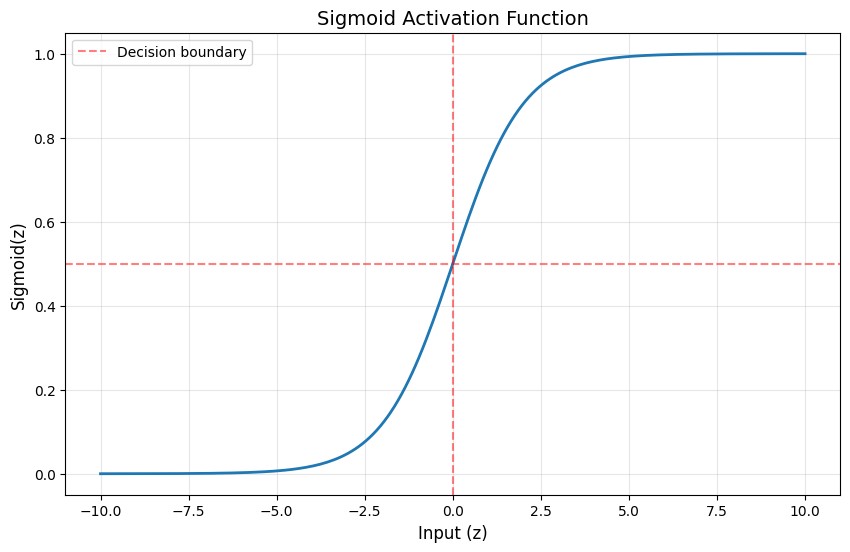

In [4]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Computes the sigmoid activation function.

    The sigmoid function maps any real-valued number to the range (0, 1),
    making it suitable for binary classification problems.

    Args:
        z: Input array of any shape.

    Returns:
        Array of same shape as z with sigmoid applied element-wise.
    """
    return 1.0 / (1 + np.exp(-z))


# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sigmoid_values = sigmoid(z_values)

plt.figure(figsize=(10, 6))
plt.plot(z_values, sigmoid_values, linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel("Input (z)", fontsize=12)
plt.ylabel("Sigmoid(z)", fontsize=12)
plt.title("Sigmoid Activation Function", fontsize=14)
plt.axhline(y=0.5, color="r", linestyle="--", alpha=0.5, label="Decision boundary")
plt.axvline(x=0, color="r", linestyle="--", alpha=0.5)
plt.legend()
plt.show()


### Parameter Initialization

We initialize the weights and biases with small random values:
- **Weights**: Random values from a normal distribution
- **Biases**: Random values (or zeros) 

Random initialization is crucial to break symmetry - if all weights were the same, all neurons in a layer would learn the same features!


In [5]:
# Initialize parameters for Layer 1 (Hidden Layer)
# W_1: (3, 10) - connects 10 inputs to 3 hidden neurons
# b_1: (3, 1) - bias for each of 3 hidden neurons
np.random.seed(10)  # For reproducibility

W_1 = np.random.normal(size=(3, X.shape[1]))
b_1 = np.random.normal(size=(3, 1))

print("Layer 1 (Hidden Layer) Parameters:")
print(f"  W_1 shape: {W_1.shape} - Weight matrix")
print(f"  b_1 shape: {b_1.shape} - Bias vector")

# Initialize parameters for Layer 2 (Output Layer)
# W_2: (1, 3) - connects 3 hidden neurons to 1 output
# b_2: (1, 1) - bias for the output neuron
W_2 = np.random.normal(size=(1, 3))
b_2 = np.random.normal(size=(1, 1))

print("\nLayer 2 (Output Layer) Parameters:")
print(f"  W_2 shape: {W_2.shape} - Weight matrix")
print(f"  b_2 shape: {b_2.shape} - Bias scalar")

# Total number of parameters
total_params = W_1.size + b_1.size + W_2.size + b_2.size
print(f"\nTotal trainable parameters: {total_params}")


Layer 1 (Hidden Layer) Parameters:
  W_1 shape: (3, 10) - Weight matrix
  b_1 shape: (3, 1) - Bias vector

Layer 2 (Output Layer) Parameters:
  W_2 shape: (1, 3) - Weight matrix
  b_2 shape: (1, 1) - Bias scalar

Total trainable parameters: 37


## Forward Propagation

**Forward propagation** is the process of computing the output of a neural network given an input. Information flows forward through the network from input to output.

### The Process (for our 2-layer network):

1. **Layer 1 Computation**:
   - Compute linear combination: $ Z^{[1]} = X (W^{[1]})^T + b^{[1]} $
   - Apply activation: $ A^{[1]} = \sigma(Z^{[1]}) $

2. **Layer 2 Computation**:
   - Compute linear combination: $ Z^{[2]} = A^{[1]} (W^{[2]})^T + b^{[2]} $
   - Apply activation: $ \hat{Y} = \sigma(Z^{[2]}) $

The final output $ \hat{Y} $ contains predicted probabilities for each sample.

### Matrix Dimensions Flow

For a batch of $n$ training samples:
- Input $ X $: $(n, 10)$
- After Layer 1: $ Z^{[1]} $: $(n, 3)$, $ A^{[1]} $: $(n, 3)$
- After Layer 2: $ Z^{[2]} $: $(n, 1)$, $ \hat{Y} $: $(n, 1)$

Let's implement this step by step!


In [6]:
# Forward propagation - Layer 1 (Hidden Layer)
print("=" * 60)
print("LAYER 1: HIDDEN LAYER COMPUTATION")
print("=" * 60)

# Step 1a: Linear transformation
# Z_1 = X @ W_1.T + b_1.T
# Each row of X (a sample) is multiplied by W_1.T to get 3 values
Z_1 = X @ W_1.T
print(f"\nStep 1a - Linear transformation (Z_1 = X @ W_1.T):")
print(f"  Input shape: {X.shape}")
print(f"  Weight matrix shape: {W_1.T.shape}")
print(f"  Output Z_1 shape: {Z_1.shape}")
print(f"\n  Sample Z_1 values (first 3 samples):")
print(Z_1[:3])

# Step 1b: Add bias and apply activation
# A_1 = sigmoid(Z_1 + b_1.T)
A_1 = sigmoid(Z_1 + b_1.T)
print(f"\nStep 1b - Add bias and apply sigmoid (A_1 = sigmoid(Z_1 + b_1.T)):")
print(f"  Bias shape: {b_1.T.shape}")
print(f"  Output A_1 shape: {A_1.shape}")
print(f"\n  Sample A_1 values (first 3 samples):")
print(A_1[:3])
print(f"\n  A_1 contains {A_1.shape[1]} activations per sample")
print(f"  (one for each hidden neuron)")


LAYER 1: HIDDEN LAYER COMPUTATION

Step 1a - Linear transformation (Z_1 = X @ W_1.T):
  Input shape: (455, 10)
  Weight matrix shape: (10, 3)
  Output Z_1 shape: (455, 3)

  Sample Z_1 values (first 3 samples):
[[ 0.16410112 -4.76306361  3.93309998]
 [-0.46604358  4.1992739   9.5658238 ]
 [-1.60754809 -0.23753874 -1.01727238]]

Step 1b - Add bias and apply sigmoid (A_1 = sigmoid(Z_1 + b_1.T)):
  Bias shape: (1, 3)
  Output A_1 shape: (455, 3)

  Sample A_1 values (first 3 samples):
[[0.47421887 0.00490603 0.98314001]
 [0.32445766 0.97466643 0.99993863]
 [0.13297977 0.31284592 0.29223288]]

  A_1 contains 3 activations per sample
  (one for each hidden neuron)


In [7]:
# Forward propagation - Layer 2 (Output Layer)
print("\n" + "=" * 60)
print("LAYER 2: OUTPUT LAYER COMPUTATION")
print("=" * 60)

# Step 2a: Linear transformation
# Z_2 = A_1 @ W_2.T
Z_2 = A_1 @ W_2.T
print(f"\nStep 2a - Linear transformation (Z_2 = A_1 @ W_2.T):")
print(f"  Input shape: {A_1.shape}")
print(f"  Weight matrix shape: {W_2.T.shape}")
print(f"  Output Z_2 shape: {Z_2.shape}")
print(f"\n  Sample Z_2 values (first 3 samples):")
print(Z_2[:3])

# Step 2b: Add bias and apply activation
# A_2 = Y_hat = sigmoid(Z_2 + b_2.T)
A_2 = y_hat = sigmoid(Z_2 + b_2.T)
print(f"\nStep 2b - Add bias and apply sigmoid (A_2 = sigmoid(Z_2 + b_2.T)):")
print(f"  Bias shape: {b_2.T.shape}")
print(f"  Output A_2 (Y_hat) shape: {A_2.shape}")
print(f"\n  Sample predictions (first 5 samples):")
print(A_2[:5])
print(f"\n  These are predicted probabilities for class 1 (malignant)")
print(f"  Values close to 1 = likely malignant")
print(f"  Values close to 0 = likely benign")



LAYER 2: OUTPUT LAYER COMPUTATION

Step 2a - Linear transformation (Z_2 = A_1 @ W_2.T):
  Input shape: (455, 3)
  Weight matrix shape: (3, 1)
  Output Z_2 shape: (455, 1)

  Sample Z_2 values (first 3 samples):
[[-0.02765076]
 [ 1.31583817]
 [ 0.4030225 ]]

Step 2b - Add bias and apply sigmoid (A_2 = sigmoid(Z_2 + b_2.T)):
  Bias shape: (1, 1)
  Output A_2 (Y_hat) shape: (455, 1)

  Sample predictions (first 5 samples):
[[0.59207723]
 [0.84761911]
 [0.69066552]
 [0.76062638]
 [0.82363926]]

  These are predicted probabilities for class 1 (malignant)
  Values close to 1 = likely malignant
  Values close to 0 = likely benign


### Creating a Forward Propagation Function

Now let's package the forward propagation logic into a reusable function. This will be useful when we train the network in the next notebook.


In [8]:
def forward_propagation(
    X: np.ndarray,
    W_1: np.ndarray,
    b_1: np.ndarray,
    W_2: np.ndarray,
    b_2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Performs forward propagation through a 2-layer neural network.

    Computes the activations for each layer by applying linear transformations
    followed by sigmoid activations. Returns all intermediate values which are
    needed for backpropagation during training.

    Args:
        X: Input data of shape (n_samples, n_features).
        W_1: Weight matrix for layer 1 of shape (n_hidden, n_features).
        b_1: Bias vector for layer 1 of shape (n_hidden, 1).
        W_2: Weight matrix for layer 2 of shape (1, n_hidden).
        b_2: Bias scalar for layer 2 of shape (1, 1).

    Returns:
        Tuple containing:
            - A_2: Final output predictions of shape (n_samples, 1).
            - Z_2: Pre-activation values for layer 2 of shape (n_samples, 1).
            - A_1: Activations from layer 1 of shape (n_samples, n_hidden).
            - Z_1: Pre-activation values for layer 1 of shape (n_samples, n_hidden).
    """
    # Layer 1: Hidden layer computation
    Z_1 = X @ W_1.T
    A_1 = sigmoid(Z_1 + b_1.T)

    # Layer 2: Output layer computation
    Z_2 = A_1 @ W_2.T
    A_2 = sigmoid(Z_2 + b_2.T)

    return A_2, Z_2, A_1, Z_1


# Test the function
y_hat, Z_2, A_1, Z_1 = forward_propagation(X=X, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2)

print("Forward propagation function output:")
print(f"  y_hat shape: {y_hat.shape}")
print(f"  First 5 predictions: {y_hat[:5].flatten()}")


Forward propagation function output:
  y_hat shape: (455, 1)
  First 5 predictions: [0.59207723 0.84761911 0.69066552 0.76062638 0.82363926]


## Summary

In this notebook, we've covered:

1. **Neural Network Fundamentals**: Understanding the architecture, components, and why neural networks are powerful
2. **Data Preparation**: Loading and preprocessing the breast cancer dataset with proper standardization
3. **Network Architecture**: Designing a 2-layer network with 3 hidden neurons
4. **Forward Propagation**: Implementing the forward pass to compute predictions from inputs

### Key Takeaways

- Neural networks transform inputs through layers of weighted connections and non-linear activations
- Matrix operations allow efficient computation for batches of samples
- The sigmoid activation function introduces non-linearity and bounds outputs to (0, 1)
- Forward propagation computes predictions, but with random weights, predictions are not yet accurate

### What's Next?

The predictions from our randomly initialized network are not useful yet! In the next notebook (**17_neural_network_training.ipynb**), we'll learn:
- How to measure prediction quality using a loss function
- **Backpropagation**: Computing gradients to update parameters
- **Training**: Using gradient descent to learn optimal weights
- Implementing the same network in **PyTorch** for easier development

With proper training, our network will learn to accurately classify tumors!
